# Livability Analysis

In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime
import folium
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, functions as F

In [2]:
# spark session initialization
spark = SparkSession.builder\
    .master("local[5]")\
    .appName("main")\
    .config("spark.sql.debug.maxToStringFields", 100)\
    .config("spark.driver.memory", '4g')\
    .config("spark.executor.instances", 5)\
    .getOrCreate()

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/09 06:40:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/09 06:40:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/09 06:40:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
file_location = "results/prediction.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.csv('results/prediction.csv', header=True, inferSchema=True)

display(df)

DataFrame[id: string, line: string, stop_name: string, borough: string, n_label: string, s_label: string, entries: double, exits: double, arrests: int, complaints: int, summons: int, latitude: double, longitude: double, pred_price: double]

In [4]:
# convert borough code into names
df = df.withColumn('borough', F.when(df.borough == 'M', 'Manhattan')
                          .when(df.borough == 'Bk', 'Brooklyn')
                          .when(df.borough == 'Bx', 'Bronx')
                          .when(df.borough == 'Q', 'Queens')
                          .when(df.borough == 'SI', 'Staten Island')
                          .otherwise(df.borough))
df.toPandas()

,id,line,stop_name,borough,n_label,s_label,entries,exits,arrests,complaints,summons,latitude,longitude,pred_price
0,F12,Queens Blvd,5 Av/53 St,Manhattan,Queens,Downtown & Brooklyn,1.715401e+11,1.839895e+11,1811,3603,1056,40.760167,-73.975224,229.723626
1,637,Lexington Av,Bleecker St,Manhattan,Uptown & The Bronx,Downtown,1.965652e+11,1.534667e+11,3444,5079,1046,40.725915,-73.994659,215.209436
2,603,Pelham,Middletown Rd,Bronx,Pelham Bay Park,Manhattan,1.602757e+10,9.955782e+09,442,1094,842,40.843863,-73.836322,93.021918
3,725,Flushing,Times Sq-42 St,Manhattan,Queens,34 St - Hudson Yards,4.943579e+11,1.840059e+11,11199,12406,14342,40.755477,-73.987691,226.520469
4,606,Pelham,Zerega Av,Bronx,Pelham Bay Park,Manhattan,9.471628e+09,5.313407e+09,649,1661,996,40.836488,-73.847036,93.021918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,R22,Broadway - Brighton,Prince St,Manhattan,Uptown & Queens,Downtown & Brooklyn,1.001154e+11,6.547147e+10,7198,9826,1712,40.724329,-73.997702,224.448457
443,J15,Jamaica,Woodhaven Blvd,Queens,Jamaica,Manhattan,7.133194e+10,2.695806e+10,843,1287,832,40.693879,-73.851576,90.279575
444,D32,Broadway - Brighton,Avenue H,Brooklyn,Manhattan,Brighton Beach & Coney Island,1.206304e+10,1.096028e+10,424,814,401,40.629270,-73.961639,123.934508
445,F23,6th Av - Culver,4 Av-9 St,Brooklyn,Manhattan - Queens,Church Av - Coney Island,5.257801e+11,6.405787e+11,953,1068,597,40.670272,-73.989779,158.923898


# Number of complaints per Borough

In [5]:
# complaint analysis
count_complaints_borough = df.groupBy('borough')\
    .agg(F.sum('complaints').alias('total_complaints'))\
    .orderBy('total_complaints', ascending=False)



count_complaints_borough = count_complaints_borough.withColumn('borough', F.when(df.borough == 'M', 'Manhattan')
                          .when(df.borough == 'Bk', 'Brooklyn')
                          .when(df.borough == 'Bx', 'Bronx')
                          .when(df.borough == 'Q', 'Queens')
                          .when(df.borough == 'SI', 'Staten Island')
                          .otherwise(df.borough))

count_complaints_borough.show()

+-------------+----------------+
|      borough|total_complaints|
+-------------+----------------+
|    Manhattan|          836342|
|     Brooklyn|          399007|
|        Bronx|          245287|
|       Queens|          141828|
|Staten Island|            1561|
+-------------+----------------+



In [6]:
# convert to pandas df
borough_pddf = pd.DataFrame(count_complaints_borough.rdd.map(lambda x: x.asDict()).collect()).dropna().sort_values(by='total_complaints', ascending=False)

<Axes: title={'center': 'Number of complaints per Borough'}, xlabel='borough', ylabel='Number of complaints'>

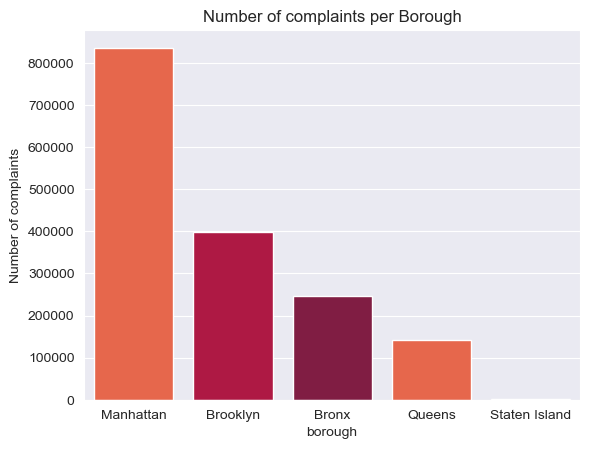

In [7]:
# plotting total number of crimes per borough
sns.set_style('darkgrid')
custom_palette = sns.color_palette(['#FF5733', '#C70039', '#900C3F'])
g=sns.barplot(x='borough',y='total_complaints',data=borough_pddf,palette=custom_palette);
plt.ylabel('Number of complaints');
plt.title("Number of complaints per Borough");
display(g)

# TOP 10 busiest stations in each Borough

In [8]:
from pyspark.sql.functions import rank
# Aggregate the data by borough and station, summing the entries for each station.
station_entries = df.groupBy(['borough', 'stop_name', 'latitude', 'longitude']).agg(F.sum('entries').alias('total_entries'))

# Rank the stations in each borough based on their entries and select the top 10.
window = Window.partitionBy('borough').orderBy(station_entries['total_entries'].desc())
station_entries = station_entries.withColumn('rank', rank().over(window))
top_stations = station_entries.filter(station_entries['rank'] <= 10)

# Create a map and add circle markers for each station.
borough_colors = {'Manhattan': 'blue', 'Brooklyn': 'green', 'Bronx': 'red', 'Queens': 'purple', 'Staten Island': 'orange'}
m = folium.Map(location=[40.730610, -73.935242], zoom_start=11, tiles="CartoDB dark_matter")

for row in top_stations.collect():
    color = borough_colors[row['borough']]
    rank = row['rank']
    stop_name = row['stop_name']
    popup_text = f"Rank: {rank}<br>Stop Name: {stop_name}"
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=5,
                        fill=True, fill_color=color, fill_opacity=0.7, color=color, popup=popup_text).add_to(m)


m